,Month,Name,Demand
35,36,Dec,322.385076
36,37,Jan,237.951698
37,38,Feb,478.870715
38,39,Mar,629.901185
39,40,Apr,921.059310


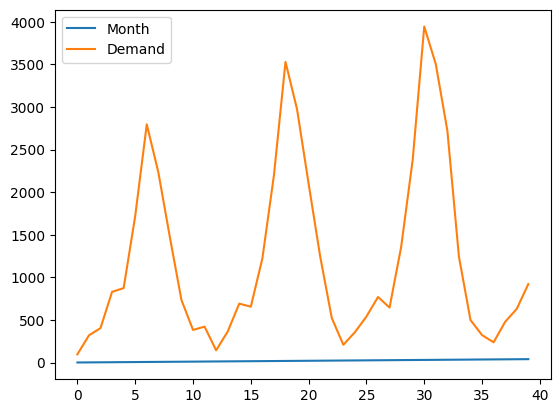

In [87]:
import pandas as pd
import numpy as np

potting_soil = pd.read_excel('potting-soil.xlsx')
potting_soil.plot()
potting_soil.tail()

## 2.4

Value for May: 1904.2514435067774


<Axes: >

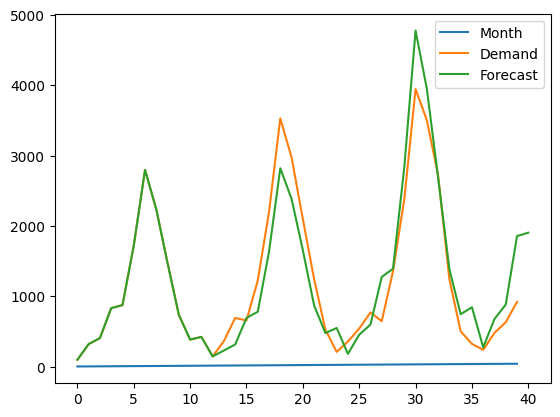

In [89]:
alpha = 0.2
beta = 0.1
gamma = 0.3

D = potting_soil["Demand"].to_numpy()

I = D[:12]
S = np.append(np.nan, D[1:12] - D[:11])
c = 12 * D[:12] / np.sum(D[:12])
y = D[:13]

for t in range(12, len(D) - 1):
    I_t = alpha * y[t] / c[t - 12] + (1 - alpha) * (I[t - 1] + S[t-1])
    I = np.append(I, I_t)
    S_t = beta * (I[t] - I[t-1]) + (1-beta) * S[t-1]
    S = np.append(S, S_t)
    c_t = gamma * y[t] / I[t] + (1 - gamma) * c[t - 12]
    c = np.append(c, c_t)
    y_t_plus_1 = (I_t + S_t) * c[(t + 1) - 12]
    y = np.append(y, y_t_plus_1)


potting_soil["Forecast"] = y

# Now using y to forecast the next month (may)
t = len(D) - 1
I_t = alpha * y[t] / c[t-12] + (1 - alpha) * (I[t-1] + S[t-1])
S_t = beta * (I_t - I[t-1]) + (1-beta) * S[t-1]
c_t = gamma * y[t] / I_t + (1 - gamma) * c[t-12]

y_may = (I_t + S_t) * c_t
print(f"Value for May: {y_may}")

# Add a new row to the dataframe
potting_soil = pd.concat([potting_soil, pd.DataFrame({"Demand": [np.nan], "Forecast": [y_may]})], ignore_index=True)

potting_soil.plot()

## 2.7
a) For the moving average we can simply use the concatenation of (D, y) for y so far. That is once we have $t$ that is greater than the length of $D$ we start using $y$.

b) Same as above

c) Same as above